In [1]:
import pandas as pd
import numpy as np
import sys

data = pd.read_csv('https://raw.githubusercontent.com/Ragnarok540/pdg/main/tags.txt', sep='~', header=None)

data.columns = ['links', 'req']

def add_categories(df):
  bins = [0, 11, 120, sys.maxsize]
  labels = ['low', 'moderate', 'high']
  category = pd.cut(df['links'], bins=bins, labels=labels)
  df['category'] = category
  return df

add_categories(data)

data["label"] = data["category"].cat.codes

data.head()

,links,req,category,label
0,198,The solution should provide detailed context s...,high,2
1,282,The solution should provide an interface for t...,high,2
2,34,"The solution should send alerts (for example, ...",moderate,1
3,8,The solution should enable the user to track t...,low,0
4,401597,The solution should enable the help desk user ...,high,2


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics

ngram = True
tf_idf = False

if ngram:
  ngram_range = (1, 3)
else:
  ngram_range = (1, 1)

count_vect = CountVectorizer(ngram_range=ngram_range)
X_train_count = count_vect.fit_transform(data['req'])

if tf_idf:
  tfidf_transformer = TfidfTransformer()
  X_train_count = tfidf_transformer.fit_transform(X_train_count)

y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X_train_count, y, test_size=0.2, random_state=1) # 80% training and 20% test

X_train_count.shape

(5291, 110291)

In [ ]:
from pprint import pprint
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier()

print('Parameters currently in use:\n')

pprint(clf.get_params())

Parameters currently in use:

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [ ]:
param_grid = {'loss': ['log'],
              'max_iter': [1000, 1500, 2000, 2500, 3000],
              'penalty': ['l1', 'l2', 'elasticnet'],
              'alpha': [0.0001, 0.001, 0.00001]}

pprint(param_grid)

{'alpha': [0.0001, 0.001, 1e-05],
 'loss': ['log'],
 'max_iter': [1000, 1500, 2000, 2500, 3000],
 'penalty': ['l1', 'l2', 'elasticnet']}


In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   26.3s finished


{'alpha': 0.0001, 'loss': 'log', 'max_iter': 1500, 'penalty': 'l2'}

In [ ]:
clf = SGDClassifier(loss='hinge', max_iter=1500)

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cf_matrix = metrics.confusion_matrix(y_test, y_pred)

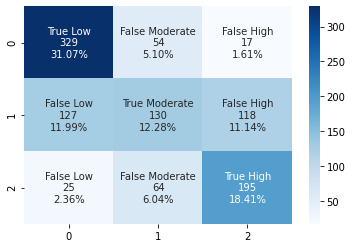

In [ ]:
import seaborn as sns

def cf_matrix_plot(cf_matrix):
  group_names = ['True Low', 'False Moderate', 'False High', 'False Low', 'True Moderate', 'False High', 'False Low', 'False Moderate', 'True High']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(3,3)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

cf_matrix_plot(cf_matrix)

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.68      0.82      0.75       400
           1       0.52      0.35      0.42       375
           2       0.59      0.69      0.64       284

    accuracy                           0.62      1059
   macro avg       0.60      0.62      0.60      1059
weighted avg       0.60      0.62      0.60      1059

